# Predicting the All Blacks Losses

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import auc
from matplotlib import pyplot
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

/home/harry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
abmatchdata = pd.read_csv('ABMatchData(FULL).csv')
irematchdata = pd.read_csv('IREMatchData(FULL).csv')

In [4]:
abmatchdata.head(5)

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss
0,Canada,2003-10-17,62,Melbourne,0,1,9,28,65.62,89.80,8
1,Tonga,2003-10-24,84,Brisbane,1,1,13,31,70.08,89.80,9
2,Wales,2003-11-02,16,Sydney,0,0,17,37,76.92,89.80,10
3,South Africa,2003-11-08,20,Melbourne,0,0,28,44,81.84,89.80,11
4,Australia,2003-11-15,-12,Sydney,0,0,41,45,86.20,90.41,12


# 1. Preparing the Features
#### We need to enumerate the location column. 0 for a neutral venue, -1 for away and 1 for home, and then create dummy columns.

In [5]:
#home cities and neutral game indexes. Neutral games have only ever happened during a worldcup plus a handful of other games
#luckily, neutral games arent common and their indexes can be found easily manually, especially with domain knowledge
AB_neutral_games = [0,1,2,3,4,49,50,52,53,64,78,92,156,157,158,159,160,161,162,173,200]
IRE_neutral_games = [0,1,3,44,45,47,88,89,90,91,92,132,133,134,135,136,145,168]

In [6]:
#add our venue column
abmatchdata['Venue'] = 0
irematchdata['Venue'] = 0

In [7]:
#define a function to enumerate the location column for neutral games only
def enum_nut(neutral_games,MatchData):
    location_num = []
    for x in range (0,len(MatchData['Location'])):
        if x in neutral_games:
            location_num.append(0)
        else:
            location_num.append(-1)
    return location_num

In [8]:
abmatchdata['Venue'] = enum_nut(AB_neutral_games,abmatchdata)
irematchdata['Venue'] = enum_nut(IRE_neutral_games,irematchdata)

In [9]:
irematchdata['Venue'].head(5)

0    0
1    0
2   -1
3    0
4   -1
Name: Venue, dtype: int64

In [10]:
#Now to just add 1's for home games
AB_homecols = [ 'Dunedin', 'Auckland','Hamilton', 'North Shore City', 'Wellington', 'Christchurch', 'New Plymouth','Napier','Nelson']
IRE_homecols = ['Lansdowne Road','Croke Park', 'Belfast', 'Limerick', 'Dublin']

In [11]:
#loop through and add 1 where needed
for x in range (0,len(abmatchdata['Location'])):
    if abmatchdata.loc[x,'Location'] in AB_homecols:
        abmatchdata.loc[x,'Venue'] = 1
                
        
for x in range (0,len(irematchdata['Location'])):
    if irematchdata.loc[x,'Location'] in IRE_homecols:
        irematchdata.loc[x,'Venue'] = 1

In [12]:
#check if venue column is complete
irematchdata.head(10)

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue
0,Namibia,2003-10-19,57,Sydney,0,0,21,25,58.76,83.92,7,0
1,Argentina,2003-10-26,1,Adelaide,0,0,36,32,79.04,83.92,8,0
2,Australia,2003-11-01,-1,Melbourne,0,0,40,28,84.76,84.95,9,-1
3,France,2003-11-09,-22,Melbourne,0,0,24,21,83.57,83.51,1,0
4,France,2004-02-14,-18,Stade de France,2,0,16,20,82.71,80.53,1,-1
5,Wales,2004-02-22,21,Lansdowne Road,0,0,15,17,77.57,79.81,1,1
6,England,2004-03-06,6,Twickenham,0,0,13,13,93.99,80.52,2,-1
7,Italy,2004-03-20,16,Lansdowne Road,2,1,2,13,72.96,82.52,3,1
8,Scotland,2004-03-27,21,Lansdowne Road,0,0,4,15,74.10,82.52,4,1
9,South Africa,2004-06-12,-14,Bloemfontein,5,0,27,17,81.23,82.52,5,-1


#### Now get dummy columns for venue

In [13]:
abdummy_cols = pd.get_dummies(abmatchdata['Venue'],prefix = 'Ven')
iredummy_cols = pd.get_dummies(irematchdata['Venue'],prefix = 'Ven')

In [14]:
#Add columns back to df
abmatchdata = pd.concat([abmatchdata,abdummy_cols], axis =1)
irematchdata = pd.concat([irematchdata,iredummy_cols], axis =1)

In [15]:
#Check dataframes
abmatchdata

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1
0,Canada,2003-10-17,62,Melbourne,0,1,9,28,65.62,89.80,8,0,0,1,0
1,Tonga,2003-10-24,84,Brisbane,1,1,13,31,70.08,89.80,9,0,0,1,0
2,Wales,2003-11-02,16,Sydney,0,0,17,37,76.92,89.80,10,0,0,1,0
3,South Africa,2003-11-08,20,Melbourne,0,0,28,44,81.84,89.80,11,0,0,1,0
4,Australia,2003-11-15,-12,Sydney,0,0,41,45,86.20,90.41,12,0,0,1,0
5,France,2003-11-20,27,Sydney,0,0,21,35,84.66,88.17,1,-1,1,0,0
6,England,2004-06-12,33,Dunedin,1,3,17,31,90.56,90.12,2,1,0,0,1
7,England,2004-06-19,24,Auckland,2,1,10,21,89.44,91.23,3,1,0,0,1
8,Argentina,2004-06-26,34,Hamilton,1,1,48,18,78.59,92.01,4,1,0,0,1
9,Pacific Is,2004-07-10,15,North Shore City,2,1,2,20,69.00,92.31,5,1,0,0,1


In [16]:
irematchdata

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1
0,Namibia,2003-10-19,57,Sydney,0,0,21,25,58.76,83.92,7,0,0,1,0
1,Argentina,2003-10-26,1,Adelaide,0,0,36,32,79.04,83.92,8,0,0,1,0
2,Australia,2003-11-01,-1,Melbourne,0,0,40,28,84.76,84.95,9,-1,1,0,0
3,France,2003-11-09,-22,Melbourne,0,0,24,21,83.57,83.51,1,0,0,1,0
4,France,2004-02-14,-18,Stade de France,2,0,16,20,82.71,80.53,1,-1,1,0,0
5,Wales,2004-02-22,21,Lansdowne Road,0,0,15,17,77.57,79.81,1,1,0,0,1
6,England,2004-03-06,6,Twickenham,0,0,13,13,93.99,80.52,2,-1,1,0,0
7,Italy,2004-03-20,16,Lansdowne Road,2,1,2,13,72.96,82.52,3,1,0,0,1
8,Scotland,2004-03-27,21,Lansdowne Road,0,0,4,15,74.10,82.52,4,1,0,0,1
9,South Africa,2004-06-12,-14,Bloemfontein,5,0,27,17,81.23,82.52,5,-1,1,0,0


In [17]:
#Finally create a third dataframe that combines IRE and AB matchdata
combinedata = pd.concat([irematchdata,abmatchdata],axis=0,ignore_index=True)
combinedata

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1
0,Namibia,2003-10-19,57,Sydney,0,0,21,25,58.76,83.92,7,0,0,1,0
1,Argentina,2003-10-26,1,Adelaide,0,0,36,32,79.04,83.92,8,0,0,1,0
2,Australia,2003-11-01,-1,Melbourne,0,0,40,28,84.76,84.95,9,-1,1,0,0
3,France,2003-11-09,-22,Melbourne,0,0,24,21,83.57,83.51,1,0,0,1,0
4,France,2004-02-14,-18,Stade de France,2,0,16,20,82.71,80.53,1,-1,1,0,0
5,Wales,2004-02-22,21,Lansdowne Road,0,0,15,17,77.57,79.81,1,1,0,0,1
6,England,2004-03-06,6,Twickenham,0,0,13,13,93.99,80.52,2,-1,1,0,0
7,Italy,2004-03-20,16,Lansdowne Road,2,1,2,13,72.96,82.52,3,1,0,0,1
8,Scotland,2004-03-27,21,Lansdowne Road,0,0,4,15,74.10,82.52,4,1,0,0,1
9,South Africa,2004-06-12,-14,Bloemfontein,5,0,27,17,81.23,82.52,5,-1,1,0,0


# 2. Exploratory Data Analysis
#### Add an extra column for enumerating the result column; 1 for a win/draw and 0 for a loss and then look for clusters

In [18]:
#define function for enumerating Results
def enum_res(matchdata):
    matchdata['ResultBin']=1
    for x in range(0,len(matchdata['Result'])):
        if matchdata.loc[x,'Result'] < 0:
            matchdata.loc[x,'ResultBin'] = 0

In [19]:
enum_res(abmatchdata)
enum_res(irematchdata)
enum_res(combinedata)

In [20]:
abmatchdata.head(5)

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1,ResultBin
0,Canada,2003-10-17,62,Melbourne,0,1,9,28,65.62,89.80,8,0,0,1,0,1
1,Tonga,2003-10-24,84,Brisbane,1,1,13,31,70.08,89.80,9,0,0,1,0,1
2,Wales,2003-11-02,16,Sydney,0,0,17,37,76.92,89.80,10,0,0,1,0,1
3,South Africa,2003-11-08,20,Melbourne,0,0,28,44,81.84,89.80,11,0,0,1,0,1
4,Australia,2003-11-15,-12,Sydney,0,0,41,45,86.20,90.41,12,0,0,1,0,0


In [21]:
#first isolate the numeric columns only
num_cols = ["Result","Opposition Debutants","Debutants","Opposition tries in last 5 games","Tries in last 5 games","Opposition Rating","Rating","Games since last loss","Ven_-1","Ven_0","Ven_1","ResultBin"]

In [22]:
#make dataframe from numeric columns
abdata = abmatchdata[num_cols]
iredata = irematchdata[num_cols]

In [23]:
#do some initial exploration of the data
abdata.mean()

Result                              19.951220
Opposition Debutants                 0.658537
Debutants                            0.678049
Opposition tries in last 5 games    13.385366
Tries in last 5 games               21.848780
Opposition Rating                   81.823902
Rating                              92.676878
Games since last loss                7.151220
Ven_-1                               0.448780
Ven_0                                0.102439
Ven_1                                0.448780
ResultBin                            0.882927
dtype: float64

In [24]:
iredata.mean()

Result                               6.918605
Opposition Debutants                 0.726744
Debutants                            0.761628
Opposition tries in last 5 games    14.116279
Tries in last 5 games               13.709302
Opposition Rating                   79.639593
Rating                              82.499128
Games since last loss                3.226744
Ven_-1                               0.436047
Ven_0                                0.104651
Ven_1                                0.459302
ResultBin                            0.639535
dtype: float64

In [25]:
abdata.head(5)

,Result,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1,ResultBin
0,62,0,1,9,28,65.62,89.80,8,0,1,0,1
1,84,1,1,13,31,70.08,89.80,9,0,1,0,1
2,16,0,0,17,37,76.92,89.80,10,0,1,0,1
3,20,0,0,28,44,81.84,89.80,11,0,1,0,1
4,-12,0,0,41,45,86.20,90.41,12,0,1,0,0


In [26]:
#instantiate clustering models
kmeans_ab = KMeans(n_clusters=2, random_state=1)
kmeans_ire = KMeans(n_clusters=2, random_state=1)
#get distances
ab_distances = kmeans_ab.fit_transform(abdata)
ire_distances = kmeans_ire.fit_transform(iredata)

In [27]:
#get labels
ablabels = kmeans_ab.labels_
irelabels = kmeans_ire.labels_

In [28]:
#crosstab results
pd.crosstab(ablabels,abdata["ResultBin"])

ResultBin,0,1
row_0,,
0,0,53
1,24,128


In [29]:
pd.crosstab(irelabels,iredata["ResultBin"])

ResultBin,0,1
row_0,,
0,0,53
1,62,57


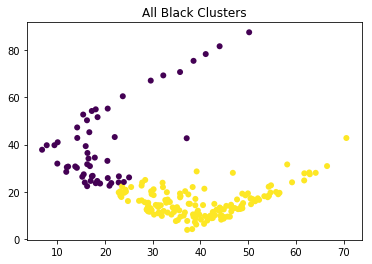

In [30]:
#scatter plot for the All Black clusters
plt.scatter(x=ab_distances[:,0], y=ab_distances[:,1], c=ablabels, linewidths=0)
plt.title('All Black Clusters')
plt.show()

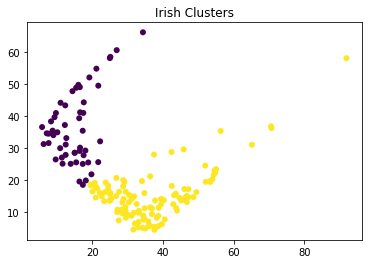

In [31]:
#scatter plot for Ireland
plt.scatter(x=ire_distances[:,0], y=ire_distances[:,1], c=irelabels, linewidths=0)
plt.title('Irish Clusters')
plt.show()

#### Unfortunately the scatter plots of the clusters didnt split along the wins and losses clearly. Try some scatter plots of the individual features against Result 

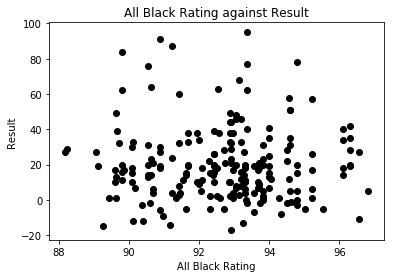

In [201]:
fig, ax = plt.subplots()
ax.scatter(abdata['Rating'], abdata['Result'],c = 'black')
ax.set_xlabel('All Black Rating')
ax.set_ylabel('Result')
ax.set_title('All Black Rating against Result')
plt.show()

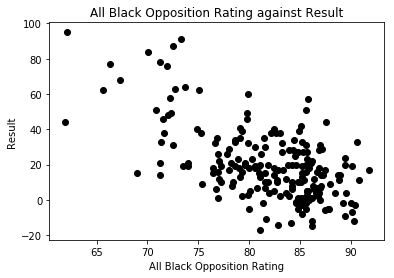

In [202]:
fig, ax = plt.subplots()
ax.scatter(abdata['Opposition Rating'], abdata['Result'],c = 'black')
ax.set_xlabel('All Black Opposition Rating')
ax.set_ylabel('Result')
ax.set_title('All Black Opposition Rating against Result')
plt.show()

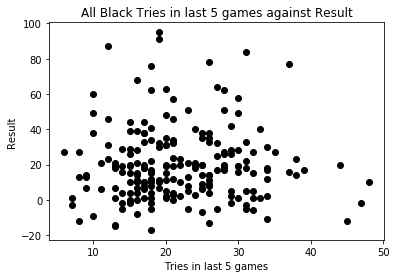

In [128]:
fig, ax = plt.subplots()
ax.scatter((abmatchdata['Tries in last 5 games']), abdata['Result'],c = 'black')
ax.set_xlabel('Tries in last 5 games')
ax.set_ylabel('Result')
ax.set_title('All Black Tries in last 5 games against Result')
plt.show()

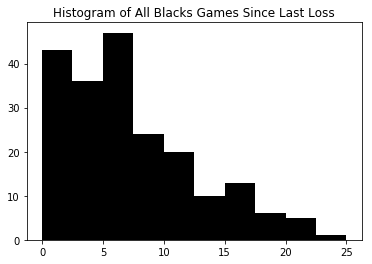

In [129]:
fig, ax = plt.subplots()
ax.hist(abmatchdata['Games since last loss'], range=(0,25),color = 'black')
ax.set_title('Histogram of All Blacks Games Since Last Loss')
plt.show()

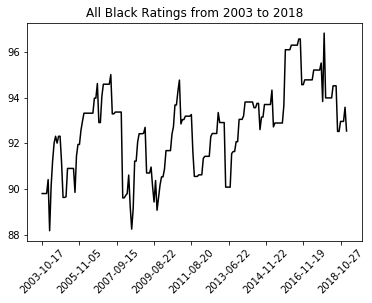

In [198]:
plt.plot(abmatchdata['Date'],abmatchdata['Rating'],c='black')
plt.xticks([0,25,50,75,100,125,150,175,200])
plt.xticks(rotation = 45)
plt.title('All Black Ratings from 2003 to 2018')
plt.show()

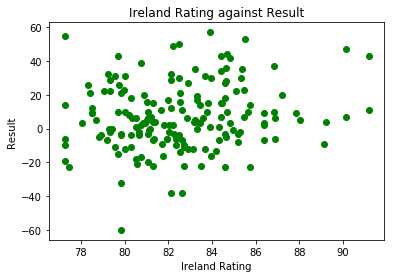

In [130]:
fig, ax = plt.subplots()
ax.scatter(iredata['Rating'], iredata['Result'],c = 'green')
ax.set_xlabel('Ireland Rating')
ax.set_ylabel('Result')
ax.set_title('Ireland Rating against Result')
plt.show()

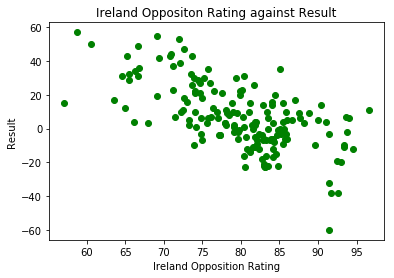

In [131]:
fig, ax = plt.subplots()
ax.scatter(iredata['Opposition Rating'], iredata['Result'],c = 'green')
ax.set_xlabel('Ireland Opposition Rating')
ax.set_ylabel('Result')
ax.set_title('Ireland Oppositon Rating against Result')
plt.show()

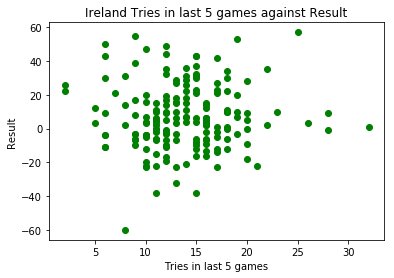

In [200]:
fig, ax = plt.subplots()
ax.scatter((irematchdata['Tries in last 5 games']), iredata['Result'],c = 'green')
ax.set_xlabel('Tries in last 5 games')
ax.set_ylabel('Result')
ax.set_title('Ireland Tries in last 5 games against Result')
plt.show()

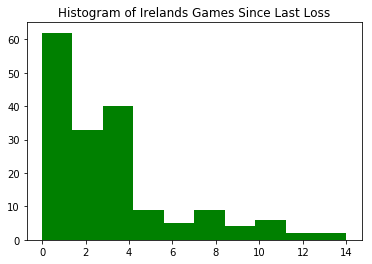

In [206]:
fig, ax = plt.subplots()
ax.hist(irematchdata['Games since last loss'], range=(0,14),color = 'green')
ax.set_title('Histogram of Irelands Games Since Last Loss')
plt.show()

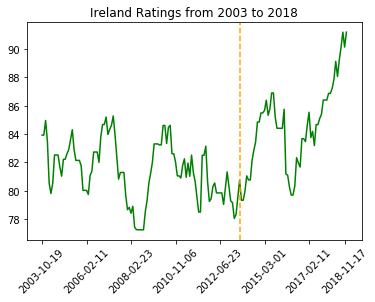

In [196]:
plt.plot(irematchdata['Date'],irematchdata['Rating'],c='green')
plt.xticks([0,25,50,75,100,125,150,170])
plt.axvline(x=111, color='orange', linestyle='--')
plt.title('Ireland Ratings from 2003 to 2018')
plt.xticks(rotation = 45)
plt.show()

#### The vertical line represents the start of Joe Schmidts tenure as head coach

# 3. Model Selection 

#### First, split data for testing and training 

In [33]:
#split the test and train dataframes(8:2)
abtrain = abmatchdata.sample(frac=0.8,random_state=200)
abtest = abmatchdata.drop(abtrain.index)
abtrain

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1,ResultBin
69,France,2009-06-13,-5,Dunedin,2,3,14,14,79.95,92.70,10,1,0,0,1,0
132,Australia,2013-10-19,8,Dunedin,1,0,10,18,84.25,93.05,10,1,0,0,1,1
188,France,2017-11-11,20,Stade de France,6,0,10,24,79.63,93.83,1,-1,1,0,0,1
192,France,2018-06-16,13,Wellington,1,0,8,23,79.10,93.99,5,1,0,0,1,1
174,Italy,2016-11-12,58,Rome,1,2,9,30,72.23,94.57,1,-1,1,0,0,1
100,South Africa,2011-08-20,-13,Port Elizabeth,0,0,6,26,84.08,93.26,8,-1,1,0,0,0
22,Australia,2005-08-13,17,Sydney,0,0,26,28,87.49,89.85,1,-1,1,0,0,1
114,Argentina,2012-09-08,16,Wellington,0,1,8,18,79.34,92.43,13,1,0,0,1,1
63,Australia,2008-09-13,4,Brisbane,1,0,11,26,86.53,91.22,4,-1,1,0,0,1
195,Australia,2018-08-25,28,Auckland,2,0,11,30,83.96,94.52,8,1,0,0,1,1


In [34]:
#do the same for IRE and combined DF

In [35]:
iretrain = irematchdata.sample(frac=0.8,random_state=200)
iretest = irematchdata.drop(iretrain.index)
comtrain = combinedata.sample(frac=0.8,random_state=200)
comtest = combinedata.drop(comtrain.index)

In [36]:
comtest

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1,ResultBin
0,Namibia,2003-10-19,57,Sydney,0,0,21,25,58.76,83.92,7,0,0,1,0,1
1,Argentina,2003-10-26,1,Adelaide,0,0,36,32,79.04,83.92,8,0,0,1,0,1
3,France,2003-11-09,-22,Melbourne,0,0,24,21,83.57,83.51,1,0,0,1,0,0
6,England,2004-03-06,6,Twickenham,0,0,13,13,93.99,80.52,2,-1,1,0,0,1
7,Italy,2004-03-20,16,Lansdowne Road,2,1,2,13,72.96,82.52,3,1,0,0,1,1
14,Italy,2005-02-06,11,Rome,0,0,20,11,72.51,82.61,4,-1,1,0,0,1
38,Scotland,2007-03-10,1,Murrayfield,0,0,10,18,74.15,84.33,2,-1,1,0,0,1
42,Scotland,2007-08-11,-10,Murrayfield,1,0,7,15,73.87,82.37,1,-1,1,0,0,0
51,Wales,2008-03-08,-4,Croke Park,0,0,17,10,77.25,78.91,2,1,0,0,1,0
52,England,2008-03-15,-23,Twickenham,1,0,5,10,83.18,77.45,1,-1,1,0,0,0


### 3.1 Logictic Regression

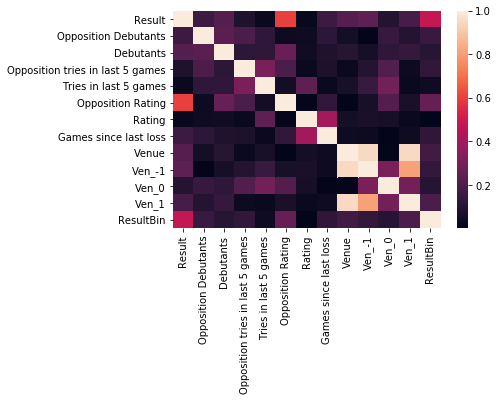

In [37]:
#start by generating a correlation matrix heatmap to select features for regression
abcorrmat = abtrain.corr().abs()
sns.heatmap(abcorrmat)

#### for the All Blacks, the biggest correlators seemed to be Opposition Rating, Venue -1,Games since last loss and Debutants

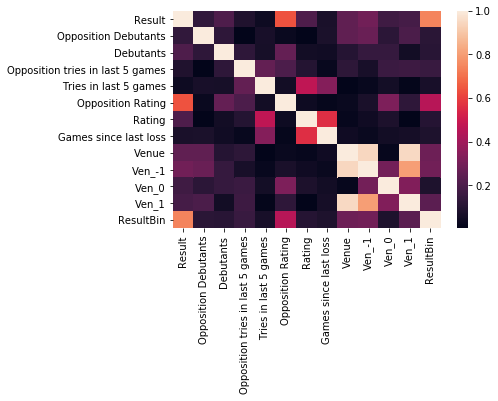

In [38]:
irecorrmat = iretrain.corr().abs()
sns.heatmap(irecorrmat)

#### For Ireland, the biggest correlators seemed to be Opposition Rating, Ven-1, Debutants and Rating

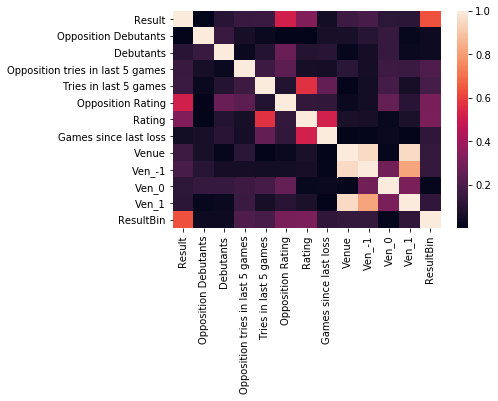

In [39]:
comcorrmat = comtrain.corr().abs()
sns.heatmap(comcorrmat)

#### <font color = red>The combined dataset showed lower correlation levels overall.</font> This was to be expected as whatever relationships that were contained within the match data specific to each team would have been 'diluted' during the combination, nevertheless, the columns with the highest scores were Opposition Rating and Rating

#### Note: There seems to be collinearity between games since last loss-rating and tries in last 5 games - rating. This makes sense since these two parameters are some of the things taken into account when World Rugby updates world rankings. We wont need to worry about this moving forward since we arent using these pairs of features for this model.

In [31]:
#define lists with the training cols
ab_cols = ['Opposition Rating','Ven_-1','Debutants','Games since last loss']
ire_cols = ['Opposition Rating','Ven_-1','Debutants','Rating']
com_cols = ['Opposition Rating','Rating']

In [32]:
#Instantiate the model objects
ablr = LogisticRegression()
irelr = LogisticRegression()
comlr = LogisticRegression()

In [33]:
#fit the models
ablr.fit(abtrain[ab_cols],abtrain['ResultBin'])
irelr.fit(iretrain[ire_cols],iretrain['ResultBin'])
comlr.fit(comtrain[com_cols],comtrain['ResultBin'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [34]:
#get predicted labels on train data
ablabels = ablr.predict(abtrain[ab_cols])
irelabels = irelr.predict(iretrain[ire_cols])
comlabels = comlr.predict(comtrain[com_cols])

In [35]:
#add the predictions to Dataframes
abtrain['Predicted_Res'] = ablabels
iretrain['Predicted_Res'] = irelabels
comtrain['Predicted_Res'] = comlabels

In [36]:
abtrain['Predicted_Res'].value_counts()

1    164
Name: Predicted_Res, dtype: int64

In [37]:
iretrain['Predicted_Res'].value_counts()

1    94
0    44
Name: Predicted_Res, dtype: int64

In [38]:
comtrain['Predicted_Res'].value_counts()

1    270
0     32
Name: Predicted_Res, dtype: int64

In [39]:
abtrain.head()

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1,ResultBin,Predicted_Res
69,France,2009-06-13,-5,Dunedin,2,3,14,14,79.95,92.70,10,1,0,0,1,0,1
132,Australia,2013-10-19,8,Dunedin,1,0,10,18,84.25,93.05,10,1,0,0,1,1,1
188,France,2017-11-11,20,Stade de France,6,0,10,24,79.63,93.83,1,-1,1,0,0,1,1
192,France,2018-06-16,13,Wellington,1,0,8,23,79.10,93.99,5,1,0,0,1,1,1
174,Italy,2016-11-12,58,Rome,1,2,9,30,72.23,94.57,1,-1,1,0,0,1,1


In [40]:
iretrain.head()

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1,ResultBin,Predicted_Res
135,France,2015-10-11,15,Millennium Stadium,0,0,14,16,81.12,84.40,4,0,0,1,0,1,1
62,Wales,2009-03-21,2,Millennium Stadium,0,0,10,11,81.88,82.01,6,-1,1,0,0,1,0
163,Scotland,2018-03-10,20,Lansdowne Road,0,0,16,19,84.43,87.21,11,1,0,0,1,1,1
74,Australia,2010-06-26,-7,Brisbane,0,3,17,13,83.83,82.61,1,-1,1,0,0,0,0
146,Canada,2016-11-12,31,Lansdowne Road,1,8,26,14,64.53,83.67,2,1,0,0,1,1,1


In [41]:
comtrain.head()

,Opposition Name,Date,Result,Location,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Venue,Ven_-1,Ven_0,Ven_1,ResultBin,Predicted_Res
122,Australia,2014-11-22,3,Lansdowne Road,0,1,11,16,84.22,84.84,7,1,0,0,1,1,1
169,Argentina,2018-11-10,11,Lansdowne Road,2,0,15,14,78.01,91.17,4,1,0,0,1,1,1
197,Wales,2005-11-05,38,Millennium Stadium,2,3,30,17,83.08,91.95,4,-1,1,0,0,1,1
304,Australia,2013-10-19,8,Dunedin,1,0,10,18,84.25,93.05,10,1,0,0,1,1,1
316,Argentina,2014-09-27,21,La Plata,0,1,8,16,73.97,93.75,22,-1,1,0,0,1,1


#### Predictions on the All Black matchdata have all been set to 1(wins), their loss:win ratio is so imbalanced that predicting a win for every single match still returns a high rate of accuracy.  Let's just see what these accuracies look like

In [42]:
#calculate accuracy of the all black model
abtrain["actual_label"] = abtrain["ResultBin"]
abmatches = abtrain["Predicted_Res"]==abtrain["actual_label"]
abcorrect_predictions = abtrain[abmatches]
abaccuracy = len(abcorrect_predictions)/len(abtrain)
abaccuracy

0.8658536585365854

In [43]:
#calculate accuracy of the ire model
iretrain["actual_label"] = iretrain["ResultBin"]
irematches = iretrain["Predicted_Res"]==iretrain["actual_label"]
irecorrect_predictions = iretrain[irematches]
ireaccuracy = len(irecorrect_predictions)/len(iretrain)
ireaccuracy

0.7318840579710145

In [44]:
#calculate accuracy of the com model
comtrain["actual_label"] = comtrain["ResultBin"]
commatches = comtrain["Predicted_Res"]==comtrain["actual_label"]
comcorrect_predictions = comtrain[commatches]
comaccuracy = len(comcorrect_predictions)/len(comtrain)
comaccuracy

0.8079470198675497

#### Overall, the raw accuracy of the models above are better than if the labels were randomly guessed (50%). However, these are most likely overfit because we generated predictions using the same data that we trained our model on. Additionally, we need other measures of effectiveness that give us more granularity than simple accuracy, lets use Specificty and Sensitivity 

In [49]:
#define function to get Specificity and Sensitivity
def get_rates(predictions,train):
# False positives.
    fp_filter = (predictions == 1) & (train["ResultBin"] == 0)
    fp = len(predictions[fp_filter])

# True positives.
    tp_filter = (predictions == 1) & (train["ResultBin"] == 1)
    tp = len(predictions[tp_filter])

# False negatives.
    fn_filter = (predictions == 0) & (train["ResultBin"] == 1)
    fn = len(predictions[fn_filter])

# True negatives
    tn_filter = (predictions == 0) & (train["ResultBin"] == 0)
    tn = len(predictions[tn_filter])
# Rates
    tpr = tp  / (tp + fn)
    fpr = fp  / (fp + tn)
    return(tpr,fpr)

In [50]:
abtpr,abfpr = get_rates(abpredictions,abtrain)

In [51]:
iretpr,irefpr = get_rates(irepredictions,iretrain)

In [52]:
comtpr,comfpr = get_rates(compredictions,comtrain)

In [53]:
print(abtpr,abfpr)#All Black Predictions

1.0 1.0


In [54]:
print(iretpr,irefpr)#Irish Predictions

0.625 0.6382978723404256


In [55]:
print(comtpr,comfpr)#Combined Predictions 

0.9106145251396648 0.9354838709677419


####  The fpr and tpr for the All Blacks and Combined data are around what we'd expect if the model was predicting all ones. We need to account for the class imbalance. Lets repeat our predictions but with a balanced weight class

In [325]:
#Instantiate the model objects again but with a balanced class weight
ablr = LogisticRegression(class_weight="balanced")
irelr = LogisticRegression(class_weight="balanced")
comlr = LogisticRegression(class_weight="balanced")

In [327]:
#fit the models
ablr.fit(abtrain[ab_cols],abtrain['ResultBin'])
irelr.fit(iretrain[ire_cols],iretrain['ResultBin'])
comlr.fit(comtrain[com_cols],comtrain['ResultBin'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [328]:
#get predicted labels on train data
abpredictions = ablr.predict(abtrain[ab_cols])
irepredictions = irelr.predict(iretrain[ire_cols])
compredictions = comlr.predict(comtrain[com_cols])

In [329]:
abtpr,abfpr = get_rates(abpredictions,abtrain)

In [330]:
iretpr,irefpr = get_rates(irepredictions,iretrain)

In [331]:
comtpr,comfpr = get_rates(compredictions,comtrain)

In [332]:
print(abtpr,abfpr)

0.5774647887323944 0.22727272727272727


In [333]:
print(iretpr,irefpr)

0.7176470588235294 0.22641509433962265


In [334]:
print(comtpr,comfpr)

0.75 0.19696969696969696


#### We improved false positive rate by balancing the classes, which reduced the true positive rate also. We can try to lower the false positive rate further by assigning a harsher penalty for misclassifying the negative class. 

In [335]:
#make dictionary for the penalty of each model
penalty = {
    0: 10,
    1: 1
}

In [336]:
#Instantiate the model objects again but with the penalty dictionary
ablr = LogisticRegression(class_weight=penalty)
irelr = LogisticRegression(class_weight=penalty)
comlr = LogisticRegression(class_weight=penalty)

In [339]:
#fit the models
ablr.fit(abtrain[ab_cols],abtrain['ResultBin'])
irelr.fit(iretrain[ire_cols],iretrain['ResultBin'])
comlr.fit(comtrain[com_cols],comtrain['ResultBin'])

LogisticRegression(C=1.0, class_weight={0: 10, 1: 1}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [340]:
#get predicted labels on train data
abpredictions = ablr.predict(abtrain[ab_cols])
irepredictions = irelr.predict(iretrain[ire_cols])
compredictions = comlr.predict(comtrain[com_cols])

In [341]:
abtpr,abfpr = get_rates(abpredictions,abtrain)

In [342]:
iretpr,irefpr = get_rates(irepredictions,iretrain)

In [343]:
comtpr,comfpr = get_rates(compredictions,comtrain)

In [344]:
print(abtpr,abfpr)

0.33098591549295775 0.13636363636363635


In [345]:
print(iretpr,irefpr)

0.3058823529411765 0.018867924528301886


In [346]:
print(comtpr,comfpr)

0.4364406779661017 0.07575757575757576


#### It looks like assigning manual penalties lowered the false positive rate to 13% in the AB dataset. Note that this comes at the expense of true positive rate. At this point neither the Balanced Classes nor the Penalty of 10 standout, although the Balanced class weights fair slightly better. Lets plot how the TPR and FPR change over different penalties to see if there exists a better option than 10:

In [347]:
def rates_list(penalty,train,cols,get_rates):
    tpr_list = []
    fpr_list = []
    for x in range (1,20):
        penalty[0] = x
        lr = LogisticRegression(class_weight=penalty)
        predictions = cross_val_predict(lr, train[cols],train['ResultBin'],cv=3)
        predictions = pd.Series(predictions)
        tpr,fpr = get_rates(predictions,train)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return(tpr_list,fpr_list) 

In [348]:
abtpr_list,abfpr_list = rates_list(penalty,abtrain,ab_cols,get_rates)

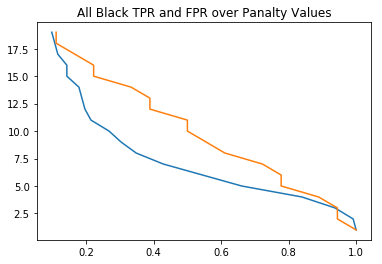

In [349]:
plt.title('All Black TPR and FPR over Penalty Values')
plt.plot(abtpr_list,[x for x in range(1,20)])
plt.plot(abfpr_list,[x for x in range(1,20)])
plt.show()

In [80]:
iretpr_list,irefpr_list = rates_list(penalty,iretrain,ire_cols,get_rates)

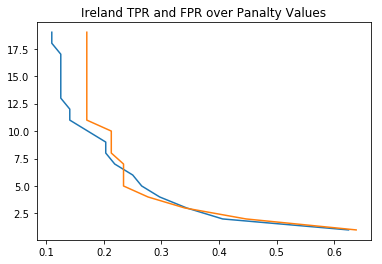

In [81]:
plt.title('Ireland TPR and FPR over Panalty Values')
plt.plot(iretpr_list,[x for x in range(1,20)])
plt.plot(irefpr_list,[x for x in range(1,20)])
plt.show()

In [82]:
comtpr_list,comfpr_list = rates_list(penalty,comtrain,com_cols,get_rates)

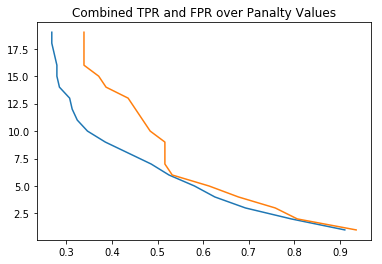

In [83]:
plt.title('Combined TPR and FPR over Panalty Values')
plt.plot(comtpr_list,[x for x in range(1,20)])
plt.plot(comfpr_list,[x for x in range(1,20)])
plt.show()

#### It seems a penalty of around 10 is the most suitable for all the models, the TPRs and FPRs are somewhat midway through their extremes at this penalty. 

#### With neither model performing well at this stage, we take them both forward and use ROC curves to evaluate our models across thresholds in order to create a more comprehensive metric. It is important to note that even though Precision-Recall curves are used when there is a moderate to large class imbalance (as there is here), the FPR is an important metric and therefore will be using ROC curves instead 

In [410]:
def plot_roc(data,cols,model,pob):#pob indicates penalty or balanced
# calculate the fpr and tpr for all thresholds of the classification
    #Instantiate the model object
    model = LogisticRegression(class_weight=pob)
    model.fit(data[cols],data['ResultBin'])
    probs = model.predict_proba(data[cols])
    preds = probs[:,1]#keep probabilities for the positive outcome only
    fpr, tpr, threshold = metrics.roc_curve(data["ResultBin"], preds)
    roc_auc = metrics.auc(fpr, tpr)
# plot ROC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    print('AUC Score:',roc_auc)

#### Plot the ROC curves for Balanced class weight models

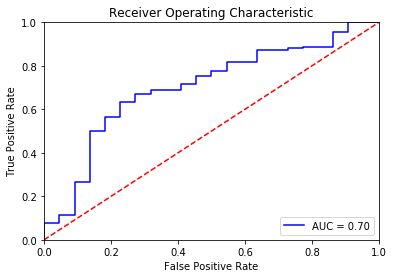

AUC Score: 0.7019846350832266


In [411]:
plot_roc(abtrain,ab_cols,ablr,"balanced")

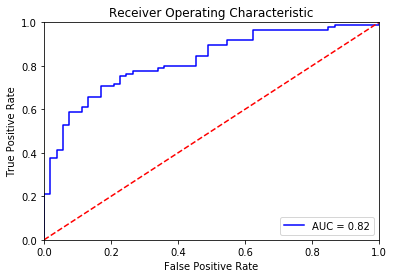

AUC Score: 0.8244173140954496


In [412]:
plot_roc(iretrain,ire_cols,irelr,"balanced")

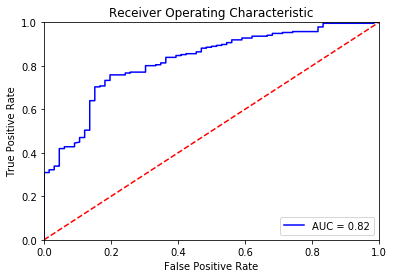

AUC Score: 0.8229006163328197


In [413]:
 plot_roc(comtrain,com_cols,comlr,"balanced")  

#### Plot the ROC curves for class weights from the Penalty dictionary

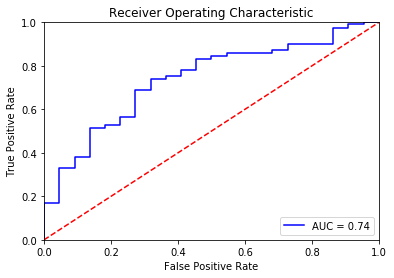

AUC Score: 0.7384763124199745


In [414]:
plot_roc(abtrain,ab_cols,ablr,penalty)

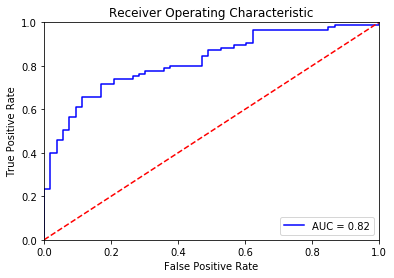

AUC Score: 0.8219755826859046


In [415]:
plot_roc(iretrain,ire_cols,irelr,penalty)

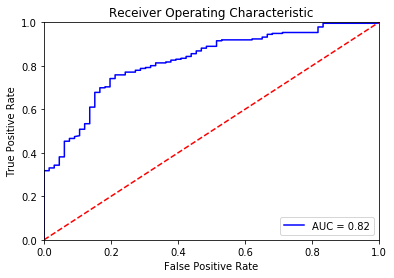

AUC Score: 0.8225796096558808


In [416]:
plot_roc(comtrain,com_cols,comlr,penalty)

#### The model that used the penalty dictionary during fitting faired slightly better at predictions for the All Blacks and the Combined dataset while the Balanced class weight model did better on the Irish dataset(although not by much at all). Lets use these models to make predictions on our test set and evaluate the models one more time

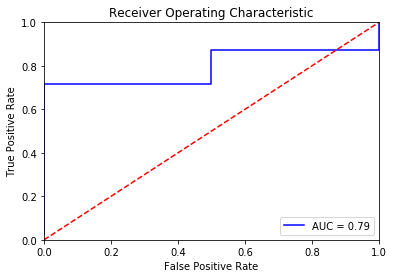

AUC Score: 0.7948717948717949


In [508]:
plot_roc(abtest,ab_cols,ablr,"balanced")

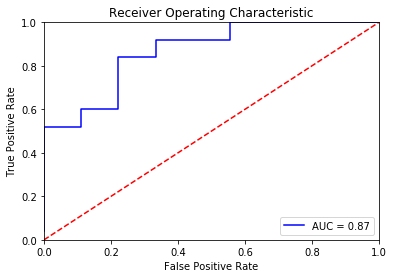

AUC Score: 0.8666666666666667


In [419]:
plot_roc(iretest,ire_cols,irelr,"balanced")

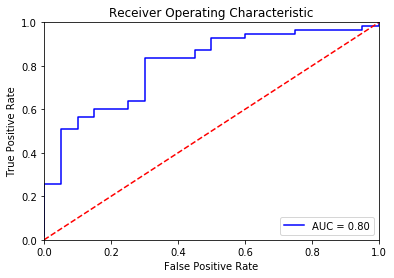

AUC Score: 0.8036363636363637


In [509]:
plot_roc(comtest,com_cols,comlr,"balanced")

#### Overall, the linear regression models arent predicting too well. Indeed, the AUCs are quite high but the class imbalance from our datasets(especially the AB set) requires the FPR to be minimized and this isnt happerneing, especially not in the model used on the AB test set and at higher ends of the threshold it actually has less skill than an unskilled model.
#### Looking back at TPRs and FPRs between the balanced class weights and the penalty class weights, the balanced model faired much better. Lets run the IRE and AB test set through the combined balanced model to see if the predictions are any better.

In [510]:
comlr = LogisticRegression(class_weight="balanced")
comlr.fit(comtrain[com_cols],comtrain['ResultBin'])
abpredictions = comlr.predict(abtest[com_cols])
abtpr,abfpr = get_rates(abpredictions,abtest)
print(abtpr,abfpr)

0.8717948717948718 0.5


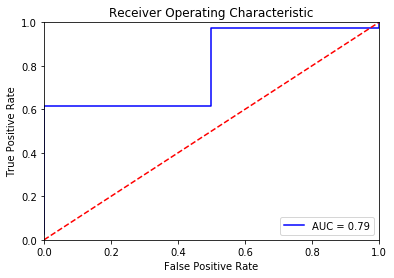

AUC Score: 0.7948717948717949


In [511]:
plot_roc(abtest,com_cols,comlr,"balanced")

0.64 0.1111111111111111


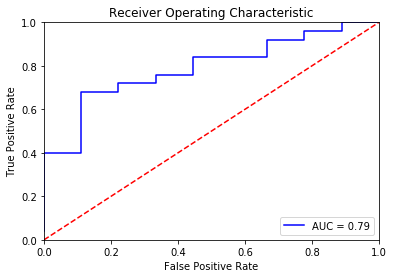

AUC Score: 0.7911111111111111


In [512]:
irepredictions = comlr.predict(iretest[com_cols])
iretpr,irefpr = get_rates(irepredictions,iretest)
print(iretpr,irefpr)
plot_roc(iretest,com_cols,comlr,"balanced")

#### These predictions are a bit better, the dip below the no-skill line is not as large as it was previously in the AB test set.
#### <font color = red>Note:</font> Due to class imbalances the AUC Scores here are most likely an over optimistic representation of the skill of the models and so either the general shape of the ROC curve or the TPR and FPR on their own at a threshold of 0.5 would be better metrics. 
#### Moving forward, create a sepeate dataframe to house actual results alongside the best predicted results from these models and all future models

In [426]:
abpredictionset = pd.DataFrame(columns=["Actual_Result"])
irepredictionset = pd.DataFrame(columns=["Actual_Result"])
compredictionset = pd.DataFrame(columns=["Actual_Result"])

In [427]:
abpredictionset["Actual_Result"] = abtest["ResultBin"]
irepredictionset["Actual_Result"] = iretest["ResultBin"]
compredictionset["Actual_Result"] = comtest["ResultBin"]

In [513]:
#Add the LogR predictions to abpredictions
model = LogisticRegression(class_weight="balanced")
model.fit(abtrain[ab_cols],abtrain['ResultBin'])
pred = model.predict(abtest[ab_cols])
abpredictionset["LogR"] = pred

In [514]:
#Add the LogR predictions to irepredictions
model = LogisticRegression(class_weight="balanced")
model.fit(iretrain[ire_cols],iretrain['ResultBin'])
pred = model.predict(iretest[ire_cols])
irepredictionset["LogR"] = pred

In [515]:
#Add the LogR predictions to compredictions
model = LogisticRegression(class_weight="balanced")
model.fit(comtrain[com_cols],comtrain['ResultBin'])
pred = model.predict(comtest[com_cols])
compredictionset["LogR"] = pred

In [516]:
#Add the LogR_Com predictions to abpredictions
model = LogisticRegression(class_weight="balanced")
model.fit(comtrain[com_cols],comtrain['ResultBin'])
pred = model.predict(abtest[com_cols])
abpredictionset["LogR_Com"] = pred

In [517]:
#Add the LogR_Com predictions to irepredictions
model = LogisticRegression(class_weight="balanced")
model.fit(comtrain[com_cols],comtrain['ResultBin'])
pred = model.predict(iretest[com_cols])
irepredictionset["LogR_Com"] = pred

In [519]:
abpredictionset    

,Actual_Result,LogR,LogR_Com,RF,RFcom
1,1,1,1,1,1
7,1,1,0,1,1
14,1,1,1,1,1
16,1,0,1,1,1
20,1,1,1,1,1
23,1,1,0,1,1
26,1,1,1,1,1
35,1,0,1,1,1
42,1,1,1,1,1
51,1,0,1,1,1


 #### Lets now move on to other models. 

### 3.2 Random Forrests

#### The workflow for finding the ideal Random Forrests model will be slightly different from the Linear Regression models. 
#### We'll find which randaomforrests model produces the best AUCs with the least overfitting  (by testing on the test datasets straight after fitting) and only then evaluate its TPR and FPR for the sole purpose of enabling comparisons to other models. 

In [520]:
#instantiate the models
abrf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=2)
irerf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=2)
comrf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=2)

#### Since random forrests dont assume a linear relationship we can start off by using all columns and not worry about correlations

In [620]:
#get list of all columns except result and venue and others
aballcols = abtrain.columns.values
ireallcols = iretrain.columns.values
comallcols = comtrain.columns.values
aballcols = np.delete(aballcols,[0,1,2,3,11,15,16,17],axis=0)
ireallcols = np.delete(ireallcols,[0,1,2,3,11,15,16,17],axis=0)
comallcols = np.delete(comallcols,[0,1,2,3,11,15,16,17],axis=0)

In [621]:
#fit the models
abrf.fit(abtrain[aballcols],abtrain["ResultBin"])
irerf.fit(iretrain[ireallcols],iretrain["ResultBin"])
comrf.fit(comtrain[comallcols],comtrain["ResultBin"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [623]:
#make predictions on training sets
abtrain_pred = abrf.predict(abtrain[aballcols])
iretrain_pred = irerf.predict(iretrain[ireallcols])
comtrain_pred = comrf.predict(comtrain[comallcols])

In [624]:
#compute AUC for the training sets
abtrain_auc = roc_auc_score(abtrain["ResultBin"],abtrain_pred)
iretrain_auc = roc_auc_score(iretrain["ResultBin"],iretrain_pred)
comtrain_auc = roc_auc_score(comtrain["ResultBin"],comtrain_pred)

In [625]:
print(abtrain_auc,iretrain_auc,comtrain_auc)

0.5227272727272727 0.8680355160932297 0.776065742167437


In [627]:
#make predictions on test sets
abtest_pred = abrf.predict(abtest[aballcols])
iretest_pred = irerf.predict(iretest[ireallcols])
comtest_pred = comrf.predict(comtest[comallcols])

In [628]:
#compute AUC for the test sets
abtest_auc = roc_auc_score(abtest["ResultBin"],abtest_pred)
iretest_auc = roc_auc_score(iretest["ResultBin"],iretest_pred)
comtest_auc = roc_auc_score(comtest["ResultBin"],comtest_pred)

In [629]:
print(abtest_auc,iretest_auc,comtest_auc)

0.5 0.7333333333333334 0.6227272727272728


#### The fact that the test AUCs are somewhat comparable indicates that the model isn't overfitting much. Train a similar random forest model and contrast it

In [630]:
#instantiate the models with different min_samples_leaf
abrf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=5)
irerf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=5)
comrf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=5)

In [631]:
#fit the models
abrf.fit(abtrain[aballcols],abtrain["ResultBin"])
irerf.fit(iretrain[ireallcols],iretrain["ResultBin"])
comrf.fit(comtrain[comallcols],comtrain["ResultBin"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [632]:
#make predictions on training sets
abtrain_pred = abrf.predict(abtrain[aballcols])
iretrain_pred = irerf.predict(iretrain[ireallcols])
comtrain_pred = comrf.predict(comtrain[comallcols])

In [633]:
#compute AUC for the training sets
abtrain_auc = roc_auc_score(abtrain["ResultBin"],abtrain_pred)
iretrain_auc = roc_auc_score(iretrain["ResultBin"],iretrain_pred)
comtrain_auc = roc_auc_score(comtrain["ResultBin"],comtrain_pred)

In [634]:
print(abtrain_auc,iretrain_auc,comtrain_auc)

0.5227272727272727 0.8680355160932297 0.776065742167437


In [635]:
#make predictions on test sets
abtest_pred = abrf.predict(abtest[aballcols])
iretest_pred = irerf.predict(iretest[ireallcols])
comtest_pred = comrf.predict(comtest[comallcols])

In [636]:
#compute AUC for the test sets
abtest_auc = roc_auc_score(abtest["ResultBin"],abtest_pred)
iretest_auc = roc_auc_score(iretest["ResultBin"],iretest_pred)
comtest_auc = roc_auc_score(comtest["ResultBin"],comtest_pred)

In [637]:
print(abtest_auc,iretest_auc,comtest_auc)

0.5 0.7333333333333334 0.6227272727272728


#### The AUC for predictions stayed the same for the second RandomForrest model
#### Lets move forward and get the FPR and TPR

In [638]:
abtpr,abfpr = get_rates(abtest_pred,abtest)

In [639]:
iretpr,irefpr = get_rates(iretest_pred,iretest)

In [640]:
comtpr,comfpr = get_rates(comtest_pred,comtest)

In [641]:
print(abtpr,abfpr)

1.0 1.0


In [642]:
print(iretpr,irefpr)

0.8 0.3333333333333333


In [643]:
print(comtpr,comfpr)

0.9454545454545454 0.7


#### The TPRs and FPRS aren't showing much promise. Lets re-do the random forrests model using the columns with high correalations instead and see if it fairs any better.

In [660]:
#instantiate the models
abrf = RandomForestClassifier(n_estimators=200, random_state=1, min_samples_leaf=5)
irerf = RandomForestClassifier(n_estimators=200, random_state=1, min_samples_leaf=5)
comrf = RandomForestClassifier(n_estimators=200, random_state=1, min_samples_leaf=5)

In [661]:
#fit the models
abrf.fit(abtrain[ab_cols],abtrain["ResultBin"])
irerf.fit(iretrain[ire_cols],iretrain["ResultBin"])
comrf.fit(comtrain[com_cols],comtrain["ResultBin"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [662]:
#make predictions on training sets
abtrain_pred = abrf.predict(abtrain[ab_cols])
iretrain_pred = irerf.predict(iretrain[ire_cols])
comtrain_pred = comrf.predict(comtrain[com_cols])

In [663]:
#compute AUC for the training sets
abtrain_auc = roc_auc_score(abtrain["ResultBin"],abtrain_pred)
iretrain_auc = roc_auc_score(iretrain["ResultBin"],iretrain_pred)
comtrain_auc = roc_auc_score(comtrain["ResultBin"],comtrain_pred)

In [664]:
print(abtrain_auc,iretrain_auc,comtrain_auc)

0.6363636363636364 0.8586015538290788 0.7894196199280945


In [665]:
#make predictions on test sets
abtest_pred = abrf.predict(abtest[ab_cols])
iretest_pred = irerf.predict(iretest[ire_cols])
comtest_pred = comrf.predict(comtest[com_cols])

In [666]:
#compute AUC for the test sets
abtest_auc = roc_auc_score(abtest["ResultBin"],abtest_pred)
iretest_auc = roc_auc_score(iretest["ResultBin"],iretest_pred)
comtest_auc = roc_auc_score(comtest["ResultBin"],comtest_pred)

In [667]:
print(abtest_auc,iretest_auc,comtest_auc)

0.47435897435897434 0.6933333333333334 0.5795454545454546


#### The AUC scores seem to suggest a level of overfitting taking place. Lets move forward and get the FPR and TPR anyway

In [668]:
abtpr,abfpr = get_rates(abtest_pred,abtest)
iretpr,irefpr = get_rates(iretest_pred,iretest)
comtpr,comfpr = get_rates(comtest_pred,comtest)

In [671]:
print(abtpr,abfpr)

0.9487179487179487 1.0


In [672]:
print(iretpr,irefpr)

0.72 0.3333333333333333


In [673]:
print(comtpr,comfpr)

0.9090909090909091 0.75


#### The only acceptable FPR and TPR is from the IRE dataset and model

#### Lastly, make predictions on the AB and IRE test sets using the combined model and compute FPR and TPR 

In [675]:
#make predictions on test sets using the combined model
abtest_pred2 = comrf.predict(abtest[com_cols])
iretest_pred2 = comrf.predict(iretest[com_cols])

In [676]:
#compute AUC again
abtest_auc2 = roc_auc_score(abtest["ResultBin"],abtest_pred2)
iretest_auc2 = roc_auc_score(iretest["ResultBin"],iretest_pred2)

In [677]:
print(abtest_auc2,iretest_auc2)

0.75 0.6622222222222223


In [678]:
#get rates
abtpr,abfpr = get_rates(abtest_pred2,abtest)
iretpr,irefpr = get_rates(iretest_pred2,iretest)

In [679]:
print(abtpr,abfpr)

1.0 0.5


In [680]:
print(iretpr,irefpr)

0.88 0.5555555555555556


#### Thus far, the combined model for RandomForrests shows the most promise for predicting an All Blacks loss; with 100% TPR and 50% FPR. In other words, all wins were successfully predicted and half of all losses were succesfully predicted. Let's re-run the prediction on the AB and IRE train sets just to see if we can replicate the same quality predictions

In [687]:
#make predictions on test sets using the combined model
abtrain_pred3 = comrf.predict(abtrain[com_cols])
#compute AUC again
abtrain_auc3 = roc_auc_score(abtrain["ResultBin"],abtrain_pred3)
#get rates
abtpr,abfpr = get_rates(abtrain_pred3,abtrain)
print(abtrain_auc3)
print(abtpr,abfpr)

0.541933418693982
0.9929577464788732 0.9090909090909091


In [686]:
#make predictions on test sets using the combined model
iretrain_pred3 = comrf.predict(iretrain[com_cols])
#compute AUC again
iretrain_auc3 = roc_auc_score(iretrain["ResultBin"],iretrain_pred3)
#get rates
iretpr,irefpr = get_rates(iretrain_pred3,iretrain)
print(iretrain_auc3)
print(iretpr,abfpr)

0.8032186459489458
0.8705882352941177 0.2641509433962264


#### Unfortunately the predictions were not replicable on the larger training set of AB data(But were somewhat replicated on the IRE training set). The quality predictions could be a fluke however given the black box nature of decision trees, its hard to say. 
#### Add the best predictions from the random forrest to the prediction dataframes

In [688]:
#Add the RF and RFcom predictions
abpredictionset["RF"] = abtest_pred
irepredictionset["RF"] = iretest_pred
compredictionset["RF"] = comtest_pred
abpredictionset["RFcom"] = abtest_pred2
irepredictionset["RFcom"] = iretest_pred2

In [689]:
irepredictionset.head(15)

,Actual_Result,LogR,LogR_Com,RF,RFcom,DNN
1,1,1,1,1,1,1
7,1,1,1,1,1,1
14,1,1,1,1,1,1
16,1,1,0,0,1,1
20,1,1,1,1,1,1
23,1,1,1,1,1,1
26,1,0,0,0,1,1
35,1,1,1,1,1,1
42,0,1,1,1,1,1
51,0,1,0,1,1,1


In [690]:
abpredictionset

,Actual_Result,LogR,LogR_Com,RF,RFcom
1,1,1,1,1,1
7,1,1,0,1,1
14,1,1,1,1,1
16,1,0,1,1,1
20,1,1,1,1,1
23,1,1,0,1,1
26,1,1,1,1,1
35,1,0,1,1,1
42,1,1,1,1,1
51,1,0,1,1,1


### 3.3 DNN

In [715]:
#instantiate the models,start with tanh activation first
abmlp = MLPClassifier(hidden_layer_sizes=(100,10),activation='tanh',max_iter=1000)
iremlp = MLPClassifier(hidden_layer_sizes=(100,10),activation='tanh',max_iter=1000)
commlp = MLPClassifier(hidden_layer_sizes=(100,10),activation='tanh',max_iter=1000)

In [716]:
#fit the models on the training sets
abmlp.fit(abtrain[aballcols],abtrain["ResultBin"])
iremlp.fit(iretrain[ireallcols],iretrain["ResultBin"])
commlp.fit(comtrain[comallcols],comtrain["ResultBin"])

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [717]:
#make predictions on test set
abnn_pred=abmlp.predict(abtest[aballcols])
irenn_pred=iremlp.predict(iretest[ireallcols])
comnn_pred=commlp.predict(comtest[comallcols])

In [694]:
#get rates
abtpr,abfpr = get_rates(abnn_pred,abtest)
iretpr,irefpr = get_rates(irenn_pred,iretest)
comtpr,comfpr = get_rates(comnn_pred,comtest)

In [695]:
print(abtpr,abfpr)

1.0 1.0


In [696]:
print(iretpr,irefpr)

0.72 0.3333333333333333


In [697]:
print(comtpr,comfpr)

0.8909090909090909 0.5


In [699]:
#use the combined model to predict AB and IRE data
abnn_pred2=commlp.predict(abtest[comallcols])
irenn_pred2=commlp.predict(iretest[comallcols])

In [700]:
#get rates
abtpr,abfpr = get_rates(abnn_pred2,abtest)
iretpr,irefpr = get_rates(irenn_pred2,iretest)

In [701]:
print(abtpr,abfpr)

0.9743589743589743 1.0


In [702]:
print(iretpr,irefpr)

0.84 0.2222222222222222


#### The TPR and FPR for a few of our models (including the combined model) are what you'd expect for a model predicting all 1's. Lets try a different activation function

In [703]:
#instantiate the models,using a different activation function
abmlp = MLPClassifier(hidden_layer_sizes=(100,10),activation='logistic',max_iter=1000)
iremlp = MLPClassifier(hidden_layer_sizes=(100,10),activation='logistic',max_iter=1000)
commlp = MLPClassifier(hidden_layer_sizes=(100,10),activation='logistic',max_iter=1000)

In [704]:
#fit the models on the training sets
abmlp.fit(abtrain[aballcols],abtrain["ResultBin"])
iremlp.fit(iretrain[ireallcols],iretrain["ResultBin"])
commlp.fit(comtrain[comallcols],comtrain["ResultBin"])

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [705]:
#make predictions on test set
abnn_pred=abmlp.predict(abtest[aballcols])
irenn_pred=iremlp.predict(iretest[ireallcols])
comnn_pred=commlp.predict(comtest[comallcols])

In [706]:
#get rates
abtpr,abfpr = get_rates(abnn_pred,abtest)
iretpr,irefpr = get_rates(irenn_pred,iretest)
comtpr,comfpr = get_rates(comnn_pred,comtest)

In [707]:
print(abtpr,abfpr)

1.0 1.0


In [708]:
print(iretpr,irefpr)

1.0 1.0


In [709]:
print(comtpr,comfpr)

0.9454545454545454 0.9


In [711]:
#use the combined model to predict AB and IRE data
abnn_pred2=commlp.predict(abtest[comallcols])
irenn_pred2=commlp.predict(iretest[comallcols])

In [712]:
#get rates
abtpr,abfpr = get_rates(abnn_pred2,abtest)
iretpr,irefpr = get_rates(irenn_pred2,iretest)

In [713]:
print(abtpr,abfpr)

1.0 1.0


In [714]:
print(iretpr,irefpr)

0.92 0.6666666666666666


#### Overall, the DNNs arent fairing very well. The only decent prediction is on the IRE dataset with the tanh activation function and for this reason, only it will be included in the prediction dataframe

In [718]:
#Add the DNN prediction to IRE
irepredictionset["DNN"] = irenn_pred

### 3.4 k-nearest neighbors

#### To prevent any single column from having too much of an impact on the Euclidean distance, normalize all of the columns to have a mean of 0 and a standard deviation of 1. 

In [742]:
#normalize train cols
norm_abtrain = abtrain[aballcols]
norm_abtrain = (norm_abtrain - norm_abtrain.mean())/(norm_abtrain .std())
norm_iretrain = iretrain[ireallcols]
norm_iretrain = (norm_iretrain - norm_iretrain.mean())/(norm_iretrain .std())
norm_comtrain = comtrain[comallcols]
norm_comtrain = (norm_comtrain - norm_comtrain.mean())/(norm_comtrain .std())

In [745]:
#normalize test cols
norm_abtest = abtest[aballcols]
norm_abtest = (norm_abtest - norm_abtest.mean())/(norm_abtest .std())
norm_iretest = iretest[ireallcols]
norm_iretest = (norm_iretest - norm_iretest.mean())/(norm_iretest .std())
norm_comtest = comtest[comallcols]
norm_comtest = (norm_comtest - norm_comtest.mean())/(norm_comtest .std())

In [744]:
#check normalized df
norm_abtrain.head(5)

,Opposition Debutants,Debutants,Opposition tries in last 5 games,Tries in last 5 games,Opposition Rating,Rating,Games since last loss,Ven_-1,Ven_0,Ven_1
69,1.260190,1.825908,0.077890,-0.992207,-0.317481,-0.008603,0.484908,-0.926483,-0.33903,1.140996
132,0.333413,-0.556975,-0.509421,-0.480503,0.421300,0.165888,0.484908,-0.926483,-0.33903,1.140996
188,4.967296,-0.556975,-0.509421,0.287053,-0.372460,0.554752,-1.171860,1.072770,-0.33903,-0.871083
192,0.333413,-0.556975,-0.803077,0.159127,-0.463519,0.634519,-0.435519,-0.926483,-0.33903,1.140996
174,0.333413,1.031614,-0.656249,1.054609,-1.643852,0.923675,-1.171860,1.072770,-0.33903,-0.871083


#### Euclidean distance begins to breakdown in dimensions higher than 3, because of this we will be using the column sets from the Logistic Regression models and not the entire column set

In [750]:
#instantiate the models
abknn = KNeighborsClassifier(algorithm='brute')
ireknn = KNeighborsClassifier(algorithm='brute')
comknn = KNeighborsClassifier(algorithm='brute')
#fit the models
abknn.fit(norm_abtrain[ab_cols],abtrain["ResultBin"])
ireknn.fit(norm_iretrain[ire_cols],iretrain["ResultBin"])
comknn.fit(norm_comtrain[com_cols],comtrain["ResultBin"])
#make predictions on test set
abknn_pred=abknn.predict(abtest[ab_cols])
ireknn_pred=ireknn.predict(iretest[ire_cols])
comknn_pred=comknn.predict(comtest[com_cols])

In [755]:
#get rates
abtpr,abfpr = get_rates(abknn_pred,abtest)
iretpr,irefpr = get_rates(ireknn_pred,iretest)
comtpr,comfpr = get_rates(comknn_pred,comtest)

In [756]:
print(abtpr,abfpr)

1.0 1.0


In [757]:
print(iretpr,irefpr)

1.0 1.0


In [758]:
print(comtpr,comfpr)

1.0 1.0


#### Unfortunately, due to the lazy nature of the kNN model, it isn't performing very well on our data and any tweaks that we may make to the kNN model is unlikely to be very beneficial at all. It doesn't generalize the underlying data i.e it doesn't produce a dicriminative function and so in order to perform well it has to be able to draw from an extremely large dataset. We shall not be adding these predictions to the prediction dataframes

In [805]:
abpredictionset

,Actual_Result,LogR,LogR_Com,RF,RFcom
1,1,1,1,1,1
7,1,1,0,1,1
14,1,1,1,1,1
16,1,0,1,1,1
20,1,1,1,1,1
23,1,1,0,1,1
26,1,1,1,1,1
35,1,0,1,1,1
42,1,1,1,1,1
51,1,0,1,1,1


In [806]:
irepredictionset

,Actual_Result,LogR,LogR_Com,RF,RFcom,DNN
1,1,1,1,1,1,0
7,1,1,1,1,1,1
14,1,1,1,1,1,1
16,1,1,0,0,1,0
20,1,1,1,1,1,1
23,1,1,1,1,1,1
26,1,0,0,0,1,1
35,1,1,1,1,1,0
42,0,1,1,1,1,1
51,0,1,0,1,1,1


In [807]:
compredictionset

,Actual_Result,LogR,RF
0,1,1,1
1,1,1,1
3,0,0,1
6,1,0,0
7,1,1,1
14,1,1,1
38,1,1,1
42,0,1,1
51,0,0,1
52,0,0,0
